## **Class activation maps (CAM)**

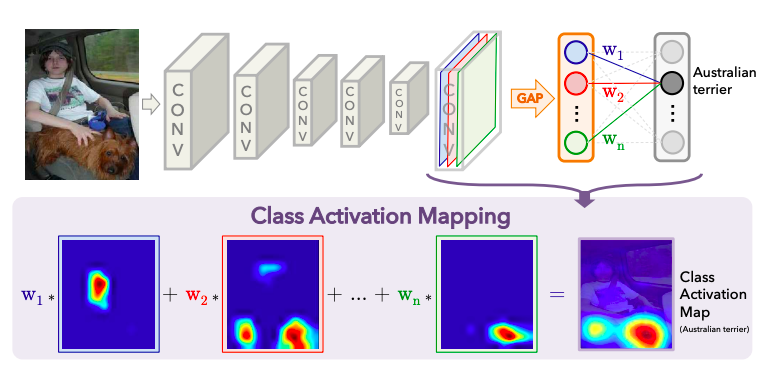

To generate the class activation map, we want to get the features detected in the last convolution layer and see which ones are most active when generating the output probabilities. You can generate the CAM by getting the dot product of the class activation features and the class activation weights.



*   In the 18 x 18 x 256 feature map, each of the 256 feature filters is tailored to look for a specific set of features (for example, nose, eye,  whiskers)
*   Each of the 256 weights for a particular class decide how much weight to give to each of the 256 features, for that class. For instance, for the "cat" class, it may have a higher weight for the feature filters that look for eyes.



In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

In [ ]:
(train_ds, val_ds, test_ds,), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files = True,
    with_info=True,
    as_supervised=True,
)

print(metadata)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteZ6TAB3/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='~/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-t

In [ ]:
len(train_ds)

18610

In [ ]:
def augment_images(image, label):

  image = tf.cast(image, tf.float32)
  
  image = (image / 255)
 
  image = tf.image.resize(image, (300, 300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_ds.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(64)

In [ ]:
model = Sequential()
model.add(Conv2D(16, input_shape=(300, 300, 3), kernel_size=(3, 3), 
                 activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(GlobalAveragePooling2D())
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 64)       0

In [ ]:
model.compile(loss="binary_crossentropy",
              metrics=["accuracy"],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
history = model.fit(train_batches, epochs=20)

Epoch 1/20
291/291 [==============================] - 74s 243ms/step - loss: 0.5818 - accuracy: 0.6963
Epoch 2/20
291/291 [==============================] - 72s 240ms/step - loss: 0.5335 - accuracy: 0.7398
Epoch 3/20
291/291 [==============================] - 72s 241ms/step - loss: 0.5012 - accuracy: 0.7601
Epoch 4/20
291/291 [==============================] - 71s 239ms/step - loss: 0.4647 - accuracy: 0.7847
Epoch 5/20
291/291 [==============================] - 72s 241ms/step - loss: 0.4260 - accuracy: 0.8107
Epoch 6/20
291/291 [==============================] - 72s 242ms/step - loss: 0.3948 - accuracy: 0.8249
Epoch 7/20
291/291 [==============================] - 71s 239ms/step - loss: 0.3633 - accuracy: 0.8435
Epoch 8/20
291/291 [==============================] - 71s 240ms/step - loss: 0.3341 - accuracy: 0.8563
Epoch 9/20
291/291 [==============================] - 72s 240ms/step - loss: 0.3083 - accuracy: 0.8678
Epoch 10/20
291/291 [==============================] - 71s 239ms/step - l

In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(256, 1)

In [ ]:
cam_model = Model(inputs=model.input, 
                  outputs=(model.layers[-3].output, 
                           model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496 

In [ ]:
def show_cam(image_value, features, results):
  
  features_for_img = features[0]
  prediction = results[0]

  class_activation_weights = gap_weights[:, 0]

  class_activation_features = sp.ndimage.zoom(features_for_img, (300/18, 300/18, 1), order=2)

  cam_output = np.dot(class_activation_features, class_activation_weights)

  print(f"sigmoid output: {results}")
  print(f"prediction : {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()

ground truth: cat
1/1 [==============================] - 0s 17ms/step
sigmoid output: [[0.00081268]]
prediction : cat


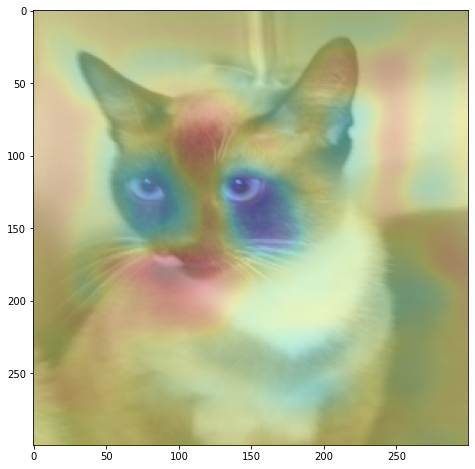

ground truth: dog
1/1 [==============================] - 0s 17ms/step
sigmoid output: [[0.5658714]]
prediction : dog


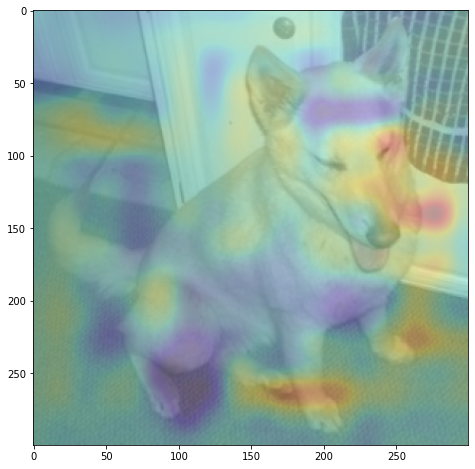

ground truth: dog
1/1 [==============================] - 0s 23ms/step
sigmoid output: [[0.9692863]]
prediction : dog


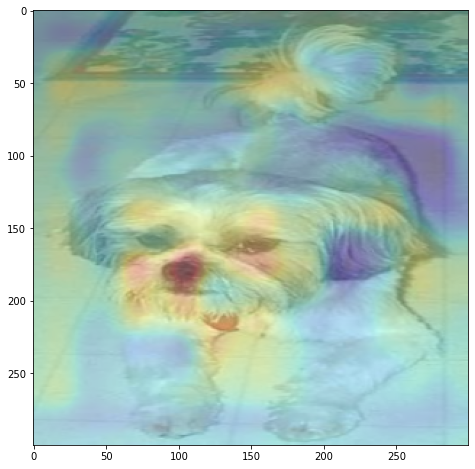

ground truth: cat
1/1 [==============================] - 0s 25ms/step
sigmoid output: [[0.00098786]]
prediction : cat


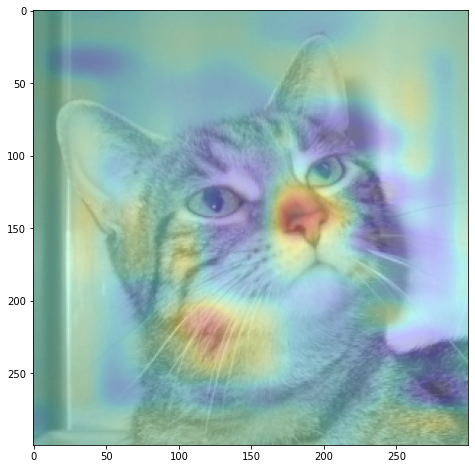

ground truth: cat
1/1 [==============================] - 0s 23ms/step
sigmoid output: [[0.04928666]]
prediction : cat


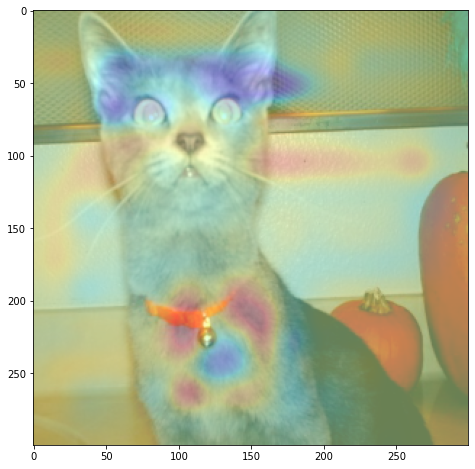

In [ ]:
augmented_test_data = test_ds.map(augment_images)
test_batches = augmented_test_data.batch(1)


for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)

In [ ]:
!wget -O cat1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
!wget -O cat2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
!wget -O dog1.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog1.jpg

--2022-11-25 12:58:15--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat1.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K  --.-KB/s    in 0.003s  

2022-11-25 12:58:15 (114 MB/s) - ‘cat1.jpg’ saved [414826/414826]

--2022-11-25 12:58:15--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/cat2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Saving to: ‘cat2.jpg’

cat2

1/1 [==============================] - 0s 18ms/step
sigmoid output: [[0.0222558]]
prediction : cat


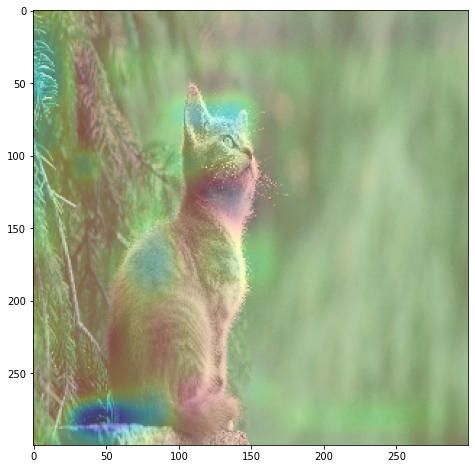

1/1 [==============================] - 0s 17ms/step
sigmoid output: [[0.00048075]]
prediction : cat


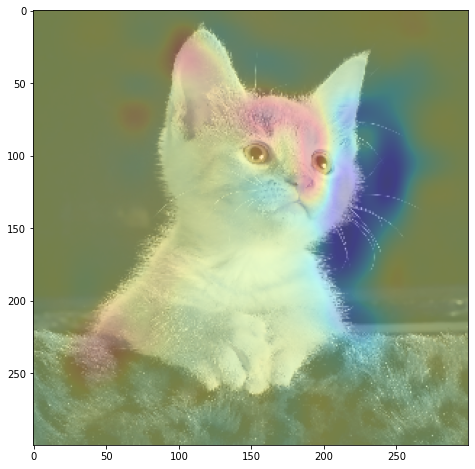

1/1 [==============================] - 0s 26ms/step
sigmoid output: [[0.7933098]]
prediction : dog


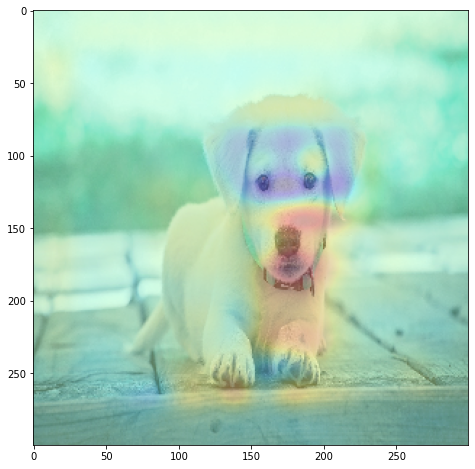

In [ ]:
def convert_and_classify(image):

  img = cv2.imread(image)

  img = cv2.resize(img, (300, 300)) / 255.0

  tensor_image = np.expand_dims(img, axis=0)

  features, results = cam_model.predict(tensor_image)
 
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('dog1.jpg')